## 1. Load data from DBPedia

In [1]:
import datasets
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
data  = pd.read_csv("data/DBPEDIA_test.csv")

In [3]:
data = data[(data.l1 == "Agent") &(data.l2.isin(["Athlete", "Politician", "Artist", "Actor"]))].reset_index(drop=True)

In [4]:
data = data[["text","l2"]]

In [5]:
data_ath, _ = train_test_split(data[data.l2 == "Athlete"],train_size=250, random_state=561)
data_pol, _ = train_test_split(data[data.l2 == "Politician"],train_size=250, random_state=561)
data_art, _ = train_test_split(data[data.l2 == "Artist"],train_size=250, random_state=561)
data_act, _ = train_test_split(data[data.l2 == "Actor"],train_size=250, random_state=561)

In [6]:
data_raw = pd.concat([data_ath, data_pol, data_art, data_act]).reset_index(drop=True).rename(columns = {"l2":"label"})

In [7]:
data_raw

,text,label
0,Matthew John King (born 25 February 1994) is a...,Athlete
1,"Carlton A. Roles (August 29, 1903 – January 16...",Athlete
2,James Thiessen (born 10 February 1974) is a fo...,Athlete
3,Alan Thomas Woodman (7 June 1955 – 8 May 2014)...,Athlete
4,"David McKinley Henderson (born July 21, 1964) ...",Athlete
...,...,...
995,"Aya Sugimoto (杉本 彩 Sugimoto Aya, born July 19,...",Actor
996,"Misty Rain (born August 10, 1969 in Long Beach...",Actor
997,"Holly Anne Hallstrom (born August 24, 1952) wa...",Actor
998,"Aya Ishizu (石津 彩 Ishizu Aya, born February 22,...",Actor


## 2. Baseline model - NMF, LSA and LDA model
### 2.1. Data Preparation

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy 
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, Nmf, LsiModel
from gensim.models.coherencemodel import CoherenceModel

In [63]:
data = load_flat_dataset("data/dbpedia_clean.csv")

In [64]:
nlp = spacy.load('en_core_web_sm')

In [65]:
docs = [nlp(" ".join(i)) for i in data]

In [66]:
texts, article = [], []
for doc in docs:
    for word in doc:

        if not word.is_stop and not word.is_punct and not word.like_num and word.text != 'I':
            article.append(word.lemma_)


    texts.append(article)
    article = []

In [67]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

### 2.2. Find the best k

In [111]:
k_ls = range(1,21,1)
co_lda = []
co_lsa = []
co_nmf = []
for k in k_ls:
    
    lda_model = LdaModel(corpus = corpus, num_topics = k, id2word = dictionary, random_state = 561, iterations=1000, chunksize=50)
    cm = CoherenceModel(model = lda_model, texts=texts, dictionary=dictionary, coherence = 'u_mass').get_coherence()
    co_lda.append(cm)
    
    nmf_model = Nmf(corpus = corpus, num_topics=k, id2word=dictionary, random_state=561, w_max_iter=1000, chunksize=50)
    cm = CoherenceModel(model = nmf_model, texts=texts, dictionary=dictionary, coherence = 'u_mass').get_coherence()
    co_nmf.append(cm)
    
    lsa_model = LsiModel(corpus = corpus, num_topics = k, id2word = dictionary, power_iters=3, chunksize=50)
    cm = CoherenceModel(model = lsa_model, texts=texts, dictionary=dictionary, coherence = 'u_mass').get_coherence()
    co_lsa.append(cm)

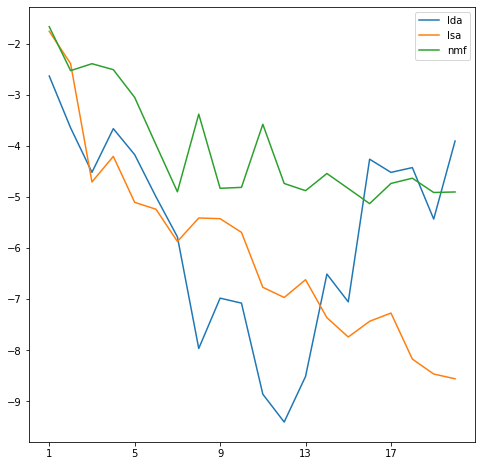

In [113]:
fig, ax = plt.subplots(figsize = (8,8))

ax.plot(k_ls, co_lda, label = "lda")
ax.plot(k_ls, co_lsa, label = "lsa")
ax.plot(k_ls, co_nmf, label = "nmf")
plt.xticks(ticks = range(1,21,4))
plt.legend()
plt.show()

### 2.3. Model with best k

In [124]:
lda_best = LdaModel(corpus = corpus, num_topics = 4, id2word = dictionary, random_state = 561, iterations=1000, chunksize=50)

nmf_best = Nmf(corpus = corpus, num_topics = 4, id2word=dictionary, random_state=561, w_max_iter=1000, chunksize=50)

lsa_best = LsiModel(corpus = corpus, num_topics = 4, id2word = dictionary, power_iters=3, chunksize=50)

In [140]:
def extract_topic(fun, corpus):
    
    topic_list = []
    
    for c in corpus:
        temp = pd.DataFrame(fun[c])
        highest = temp.iloc[:,1].argmax()
        topic_list.append(temp.iloc[highest,0])
    
    return topic_list

In [141]:
lda_topic = extract_topic(lda_best, corpus)

In [146]:
lsa_topic = extract_topic(lsa_best, corpus)

In [147]:
nmf_topic = extract_topic(nmf_best, corpus)

### 2.4. Compare results with Actual subtopics

In [90]:
docs = [str(doc) for doc in docs]

In [91]:
vocab_size = len(set(" ".join(docs).split(" ")))

In [92]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bow_featurizer = CountVectorizer(max_features=vocab_size, max_df=0.95, min_df=0.005, stop_words='english')
tfidf_featurizer = TfidfVectorizer(max_features=vocab_size, max_df=0.95, stop_words='english')
X_bow = bow_featurizer.fit_transform(docs)
X_tfidf = tfidf_featurizer.fit_transform(docs)
type(X_bow), X_bow.shape

(scipy.sparse.csr.csr_matrix, (1000, 1375))

In [93]:
from sklearn.manifold import TSNE

In [94]:
tsne = TSNE()

In [95]:
X_tsne = tsne.fit_transform(X_bow)

In [99]:
label_map = {"Athlete":0, "Politician":1, "Artist":2, "Actor":3}

In [105]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x, y)
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(x, y, 'tab:orange')
axs[0, 1].set_title('Axis [0, 1]')
axs[1, 0].plot(x, -y, 'tab:green')
axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(x, -y, 'tab:red')
axs[1, 1].set_title('Axis [1, 1]')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

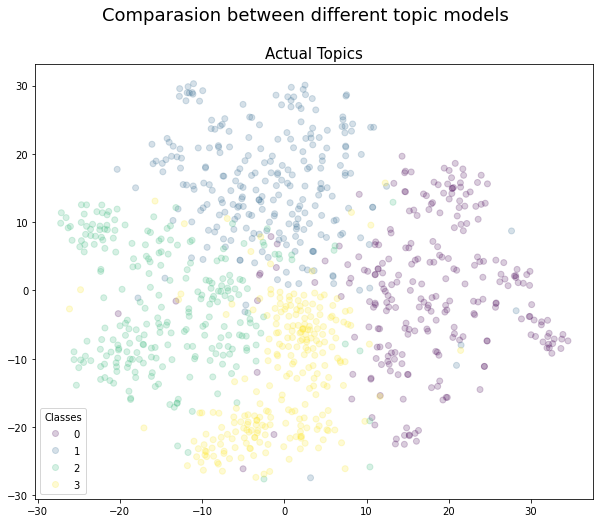

In [246]:
fig, ax = plt.subplots(figsize=(10,8))
ss = ax.scatter(X_tsne[:,0],X_tsne[:,1], c = list(data_raw.label.map(label_map)), alpha=0.2)

ax.set_title('Actual Topics', fontsize=15)



fig.suptitle("Comparasion between different topic models", fontsize=18)
plt.show()

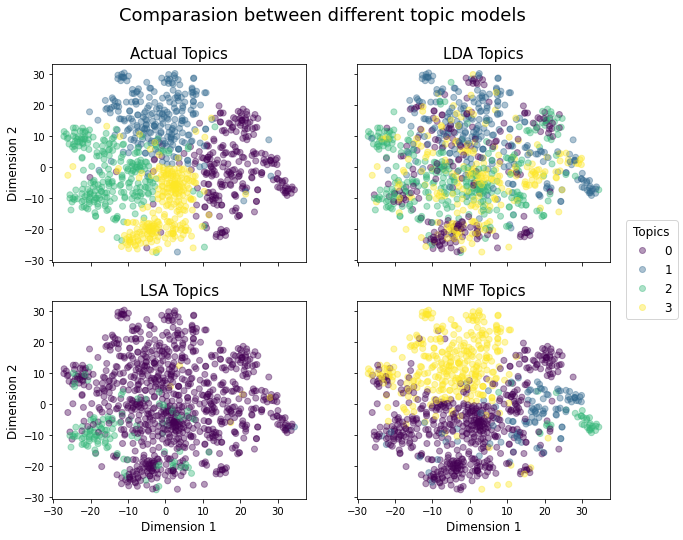

In [284]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
s1 = axs[0,0].scatter(X_tsne[:,0],X_tsne[:,1], c = list(data_raw.label.map(label_map)), alpha=0.4)
axs[0,0].set_title('Actual Topics', fontsize=15)
s2 = axs[0,1].scatter(X_tsne[:,0],X_tsne[:,1], c = lda_topic, alpha=0.4)
axs[0,1].set_title('LDA Topics', fontsize=15)
s3 = axs[1,0].scatter(X_tsne[:,0],X_tsne[:,1], c = lsa_topic, alpha=0.4)
axs[1,0].set_title('LSA Topics', fontsize=15)
s4 = axs[1,1].scatter(X_tsne[:,0],X_tsne[:,1], c = nmf_topic, alpha=0.4)
axs[1,1].set_title('NMF Topics', fontsize=15)

for ax in axs.flat:
    ax.set_xlabel(xlabel='Dimension 1', fontsize=12)
    ax.set_ylabel(ylabel='Dimension 2', fontsize=12)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle("Comparasion between different topic models", fontsize=18)
fig.legend(s1.legend_elements()[0],s2.legend_elements()[1], 
           loc="center right", title="Topics", title_fontsize=12, fontsize=12)
plt.show()

## NLDA model
### Data Preparation

In [8]:
from settings.common import get_pp_pipeline, load_flat_dataset, save_flat_dataset
from settings.ngrams import insert_ngrams_flat_from_lists
from preprocessing_pipeline.NextGen import NextGen
from settings.common import load_flat_dataset
from settings.ngrams import insert_ngrams_flat_from_lists
import csv
import matplotlib.pyplot as plt
import gensim

In [9]:
pp = get_pp_pipeline(remove_stopwords=True, stem=False, clean_twitter=False, lemmatize=True)

In [10]:
raw_data = pd.DataFrame(data_raw.text)

In [11]:
raw_data.to_csv("data/dbpedia_raw.csv", header=False, index=False)

In [12]:
dataset = load_flat_dataset("data/dbpedia_raw.csv", delimiter=' ')

In [13]:
clean_ds = []
for data in dataset:
    tokens = gensim.utils.simple_preprocess(" ".join(data))
    clean_ds.append(tokens)

In [15]:
save_flat_dataset("data/dbpedia_clean.csv", clean_ds, delimiter=' ')

In [16]:
dataset = []
from src.gdtm.helpers.common import load_flat_dataset
from src.gdtm.models import GTM, NLDA

tnd_path = 'topic-noise-models-source/mallet-tnd/bin/mallet'
lda_path = 'topic-noise-models-source/mallet-lda/bin/mallet'
gtm_path = 'topic-noise-models-source/mallet-gtm/bin/mallet'
dataset = load_flat_dataset("dbpedia_clean.csv")

In [17]:
all_bigram = []
for i in dataset:
    tmp = []
    for index in range(0,len(i)-1):
        tmp.append('$'.join(i[index:index+2]))
    all_bigram.append(tmp)
dataset.extend(all_bigram)

In [18]:
len(dataset)

2000

### Get the NLDA topics and noise

In [19]:
model = NLDA(dataset=dataset, mallet_tnd_path=tnd_path, mallet_lda_path=lda_path, 
             tnd_k=20, lda_k=20, tnd_beta1=16, phi=10, top_words=30)

In [20]:
topics = model.get_topics()
noise = model.get_noise_distribution()
topic_formula = model.show_topics()
coherence = model.get_coherent()
print("Noise:",noise)
print("\nTopics:", topic_formula)
print("\nUMass Coherence Score:", coherence)

Noise: [('of$the', 1300), ('born', 1259), ('in$the', 736), ('american', 575), ('he$was', 551), ('from$to', 400), ('to$the', 374), ('member', 366), ('served', 359), ('played', 354), ('actress', 344), ('at$the', 308), ('team', 285), ('pornographic', 247), ('actor', 242), ('party', 240), ('politician', 238), ('is$an', 218), ('member$of', 216), ('an$american', 212), ('for$the', 195), ('served$as', 190), ('won', 179), ('was$an', 173), ('elected', 167), ('in$he', 163), ('and$the', 151), ('japanese', 145), ('national', 138), ('in$and', 138), ('he$is', 136), ('governor', 135), ('time', 134), ('player', 133), ('was$the', 130), ('february', 128), ('career', 127), ('august', 126), ('september', 125), ('world', 125), ('state', 124), ('united$states', 123), ('june', 122), ('october', 120), ('january', 119), ('united', 115), ('on$the', 114), ('work', 114), ('professional', 113), ('march', 111), ('university', 111), ('april', 109), ('during$the', 108), ('december', 108), ('one$of', 106), ('comic', 10

In [21]:
noise_word = [term for term, wt in noise[:50]]
noise_wt = [wt for term, wt in noise[:50]]
noise_data = pd.DataFrame([noise_word, noise_wt]).T.rename(columns={0:"Noise_Word", 1:"Noise_Weight"}).sort_values(by="Noise_Weight", ascending=True)

In [22]:
clean_topic = []
for topic in topics:
    temp=[]
    for t in topic:
        if t not in noise_word:
            temp.append(t)
    clean_topic.append(temp)

In [23]:
print(clean_topic)

[['election', 'mayor', 'canadian', 'general', 'appointed', 'council', 'john', 'parliament', 'minister', 'house', 'south', 'term', 'county', 'conservative', 'deputy', 'north', 'local', 'held', 'federal', 'secretary', 'norwegian', 'lawyer', 'leader', 'labour', 'previously', 'assembly'], ['worked', 'york', 'award', 'fashion', 'art', 'including', 'early', 'designer', 'works', 'show', 'family', 'moved', 'business', 'city', 'radio', 'comedy', 'public', 'based', 'made', 'style', 'academy', 'chinese', 'began', 'london', 'white', 'gallery', 'studied', 'received', 'young', 'design'], ['known$for', 'for$his', 'best$known', 'comic$book', 'he$has', 'known$as', 'has$been', 'as$well', 'is$also', 'such$as', 'his$work', 'well$as', 'american$comic', 'has$also', 'and$has', 'born$october', 'is$best', 'also$known', 'october$is', 'hall$of', 'born$is', 'fashion$designer', 'who$has', 'stand$up', 'writer$and', 'born$july', 'book$artist'], ['is$japanese', 'she$was', 'japanese$voice', 'is$the', 'born$september',

In [24]:
with open("data/dbpedia_NLDA_topics.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(clean_topic)

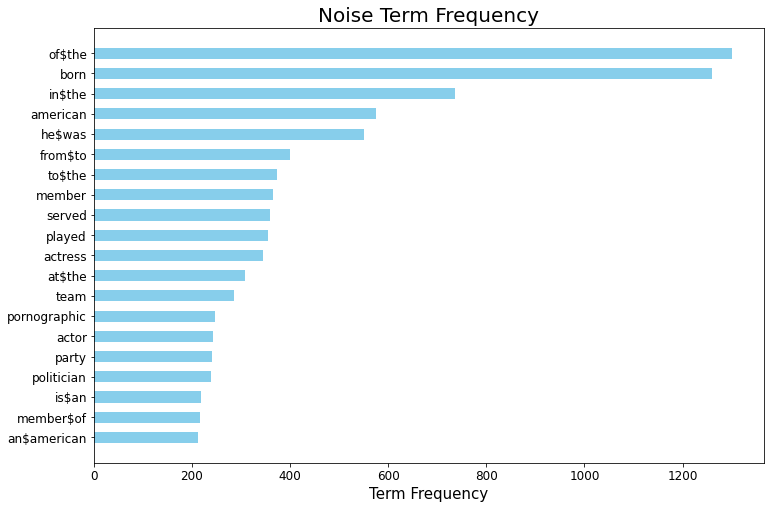

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(noise_data.Noise_Word[30:], noise_data.Noise_Weight[30:], height=0.55, color="skyblue")
plt.xlabel("Term Frequency", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Noise Term Frequency", fontsize=20)
plt.savefig("Noise.png", dpi=300)

### Guided Topic Modeling (GTM)

In [36]:
len(dataset)

2000

In [37]:
dataset = load_flat_dataset("data/dbpedia_clean.csv")

In [38]:
# add bigrams to the dataset
seed_topics_file = "data/dbpedia_seed_topics.csv"

ngrams = []
with open(seed_topics_file, 'r') as f:
    for line in f:
        topic = line.strip().split(',')
        for w in topic:
            if '$' in w:
                ngrams.append(w)
dataset = insert_ngrams_flat_from_lists(dataset, ngrams, [])
all_bigram = []
for i in dataset:
    tmp = []
    for index in range(0,len(i)-1):
        tmp.append('$'.join(i[index:index+2]))
    all_bigram.append(tmp)
dataset.extend(all_bigram)

In [39]:
model = GTM(dataset=dataset, mallet_tnd_path=tnd_path, mallet_gtm_path=gtm_path, 
              tnd_k=20, gtm_k=20, tnd_beta1 = 16, over_sampling_factor=100, phi=10,
              top_words=20,tnd_iterations=1000, gtm_iterations=1000, seed_topics_file=seed_topics_file)

In [40]:
topics = model.get_topics()
noise = model.get_noise_distribution()
topic_formula = model.show_topics()
coherence = model.get_coherent()
print("Noise:",noise)
print("\nTopics:", topic_formula)
print("\nUMass Coherence Score:", coherence)

Noise: [('in$the', 1178), ('of$the', 853), ('born', 743), ('he$was', 680), ('from$to', 398), ('member', 377), ('to$the', 375), ('actress', 346), ('american', 314), ('member$of', 308), ('at$the', 307), ('played', 301), ('governor', 265), ('politician', 255), ('pornographic', 249), ('elected', 248), ('actor', 239), ('served', 238), ('party', 235), ('is$an', 218), ('an$american', 215), ('player', 212), ('for$the', 192), ('was$an', 177), ('served$as', 175), ('team', 167), ('in$he', 167), ('and$the', 166), ('japanese', 145), ('won', 130), ('was$the', 130), ('august', 127), ('on$the', 122), ('november', 122), ('june', 122), ('world', 118), ('from$the', 117), ('september', 116), ('united', 116), ('work', 113), ('states', 111), ('state', 110), ('april', 109), ('and$was', 108), ('during$the', 108), ('series', 107), ('artist', 106), ('born$in', 103), ('national', 103), ('south', 102), ('president', 102), ('professional', 101), ('school', 101), ('comics', 100), ('is$japanese', 100), ('for$his', 9

In [41]:
noise_word = [term for term, wt in noise[:50]]
noise_wt = [wt for term, wt in noise[:50]]
noise_data = pd.DataFrame([noise_word, noise_wt]).T.rename(columns={0:"Noise_Word", 1:"Noise_Weight"}).sort_values(by="Noise_Weight", ascending=True)

In [42]:
clean_topic = []
for topic in topics:
    temp=[]
    for t in topic:
        if t not in noise_word:
            temp.append(t)
    clean_topic.append(temp)

In [43]:
print(clean_topic)

[['time', 'summer$olympics', 'competed', 'championships', 'european', 'women', 'french', 'record', 'event', 'represented', 'place', 'swimmer', 'champion', 'international', 'events', 'swimming', 'olympic'], ['comics', 'best$known', 'comic$book', 'writer', 'award', 'company', 'manga', 'comic', 'including', 'hall', 'based', 'paul', 'character', 'fame', 'long', 'illustrator'], ['was$born', 'in$and', 'and$he', 'by$the', 'of$his', 'was$also', 'died$in', 'between$and', 'he$became', 'to$be', 'he$died', 'moved$to', 'and$in', 'which$he', 'where$he', 'that$he'], ['july', 'february', 'australian', 'british', 'north', 'debut', 'rugby', 'australia', 'west', 'union', 'made', 'january', 'john', 'cricket', 'international', 'march'], ['president', 'election', 'mayor', 'canadian', 'general', 'appointed', 'council', 'parliament', 'government', 'political', 'canada', 'prime$minister', 'term', 'conservative'], ['was$elected', 'house$of', 'united$states', 'he$served', 'the$united', 'to$he', 'elected$to', 'to

In [44]:
with open("data/dbpedia_GTM_topics.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(clean_topic)

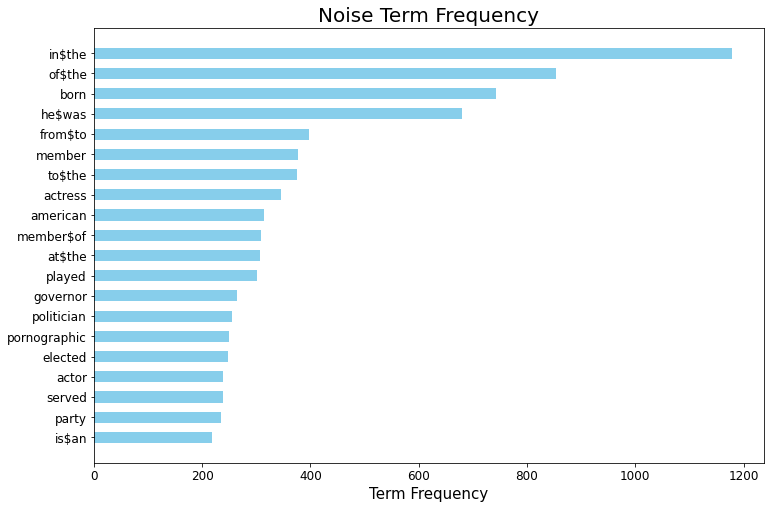

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(noise_data.Noise_Word[30:], noise_data.Noise_Weight[30:], height=0.55, color="skyblue")
plt.xlabel("Term Frequency", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Noise Term Frequency", fontsize=20)
plt.savefig("Noise.png", dpi=300)

## Mapping topics

In [166]:
data = load_flat_dataset("data/dbpedia_clean.csv")
docs = [" ".join(doc) for doc in data]

In [167]:
data_topic = pd.read_csv("data/dbpedia_mapping_topics.csv")

In [168]:
topic_list = []
for doc in docs: 
    temp = []
    for i in range(data_topic.shape[1]):
        count=0
        topic_word = list(data_topic.iloc[:,i].dropna())
        topic_word = [i.replace('$',' ') for i in topic_word]
        for word in topic_word:
            if word in doc:
                count+=1
        temp.append(count)
    topic_list.append(np.argmax(temp))

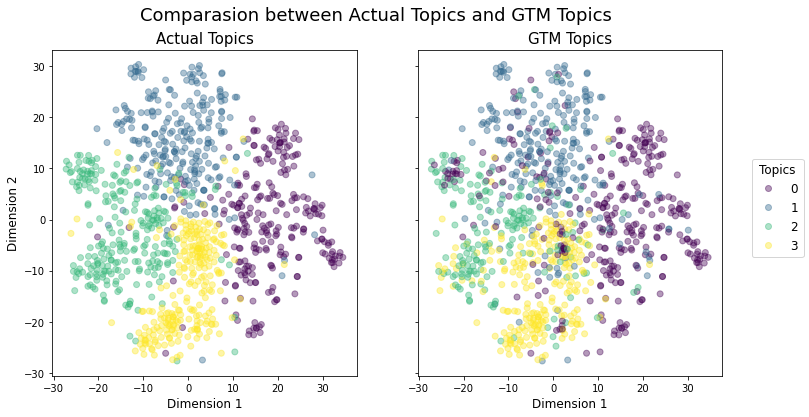

In [283]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))
s1 = axs[0].scatter(X_tsne[:,0],X_tsne[:,1], c = list(data_raw.label.map(label_map)), alpha=0.4)
axs[0].set_title('Actual Topics', fontsize=15)
s2 = axs[1].scatter(X_tsne[:,0],X_tsne[:,1], c = topic_list, alpha=0.4)
axs[1].set_title('GTM Topics', fontsize=15)

for ax in axs.flat:
    ax.set_xlabel(xlabel='Dimension 1', fontsize=12)
    ax.set_ylabel(ylabel='Dimension 2', fontsize=12)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle("Comparasion between Actual Topics and GTM Topics", fontsize=18)
fig.legend(s1.legend_elements()[0],s2.legend_elements()[1], 
           loc="center right", title="Topics", title_fontsize=12, fontsize=12)
plt.show()